# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Согласно технической документации ниже приведена расшифровка признаков в датасете.

* DateCrawled — дата скачивания анкеты из базы

* VehicleType — тип автомобильного кузова

* RegistrationYear — год регистрации автомобиля

* Gearbox — тип коробки передач

* Power — мощность (л. с.)

* Model — модель автомобиля

* Kilometer — пробег (км)

* RegistrationMonth — месяц регистрации автомобиля

* FuelType — тип топлива

* Brand — марка автомобиля

* Repaired — была машина в ремонте или нет

* DateCreated — дата создания анкеты

* NumberOfPictures — количество фотографий автомобиля

* PostalCode — почтовый индекс владельца анкеты (пользователя)

* LastSeen — дата последней активности пользователя

* Price — цена (евро)

Произведем импорт всех необходимых библиотек

In [1]:
!pip install lightgbm

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import catboost as cb
import lightgbm as lgbm

In [ ]:
sns.set(rc={"figure.figsize":(15, 9)})
sns.set_style("darkgrid")

## Подготовка данных

На данном этапе произведем выгрузку данных и изучим их более подробно.

In [3]:
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [4]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Согласно выгрузке и предствавленным данным мы видим следующее:

1) В столбцах VehicleType, Gearbox, Model, FuelType, Repaired имеются пропущенные значения.

2) В столбце NumberOfPictures количество фотографий равно 0, что достаточно странно. 

3) В столбце RegistrationYear имеются аномальные значения. Как мимимум 1000 и 9999 год регистрации.

4) В столбце Price имеется аномальное значение 0.

5) В столбце Power имеется аномальное значение 0.

6) В столбце RegistrationMonth имеется аномальное значение 0.

### Проверка дубликатов

#### Явные дубликаты

Проверим на наличие явных дубликатов в датасете.df.duplicated().sum()

In [7]:
df.duplicated().sum()

4

Избавимся от явных дубликатов.

In [8]:
df = df.drop_duplicates().reset_index(drop=True)

#### Неявные дубликаты, замена на пропусков  в категориальных признаках.

Попробуем проверить наличие неявных дубликатов. Для этого сконцентрируем внимание на столбцах с типом данных object:

- VehicleType
- Gearbox
- Model
- FuelType
- Brand
- Repaired

Проверим наличие уникальных значений.

In [9]:
df['VehicleType'].value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [10]:
df['VehicleType'].isna().sum()

37490

In [11]:
df.isna().mean()['VehicleType']

0.10579487251844849

Учитывая, что пропущенных значений порядка 10 %, а данные по машинам достаточно сильно различаются, поэтму пропущенные значения заполним  типом кузова other.

In [13]:
df['VehicleType'] = df['VehicleType'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        354365 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

In [14]:
df['Gearbox'].value_counts()

manual    268249
auto       66283
Name: Gearbox, dtype: int64

In [15]:
isna_gear_ratio = df['Gearbox'].isna().sum()/len(df['Gearbox'])
isna_gear_ratio

0.05596771690206426

Количсество пропусков составляет 5%. Можно предположить, что помимо механической или автоматической коробки передач еще существуют вариатор и роботизированная КПП. Вероятно, на сайте опции выбора альтернативных КПП нет, поэтому добавим 3-й тип other в замен пропусков.

In [16]:
df['Gearbox'] = df['Gearbox'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        354365 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            354365 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

In [17]:
df['Model'].value_counts()

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64

In [18]:
isna_model_ratio = df['Model'].isna().sum()/len(df['Model'])
isna_model_ratio

0.05560650741467131

Учитывая, что колличество пропусков по моделям составляет 5%, можно предположить, что часть моделей еще не внесено в базу данных сайта. Поэтому можно также заменить все пропуски на other.

In [19]:
df['Model'] = df['Model'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        354365 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            354365 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              354365 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

In [20]:
df['FuelType'].value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

В данных подозрительно выглядят 2 типа топлива petrol и gasoline, так как оба слова при переводе с английского являются бензином. Можно предложить данный фактор в различии страны производства: США или Европа, Россия, Азия. Проверим данную гипотезу.

In [21]:
df.loc[df['FuelType'] == 'petrol'].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58


In [22]:
df.loc[df['FuelType'] == 'petrol'].tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354354,2016-04-04 09:57:12,1490,small,1998,manual,50,lupo,150000,9,petrol,volkswagen,no,2016-04-04 00:00:00,0,48653,2016-04-06 11:17:13
354358,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016-03-19 00:00:00,0,96465,2016-03-19 20:44:43
354359,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354360,2016-03-21 09:50:58,0,other,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354362,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12


Написание на английском не зависит от региона. Поэтому можно переименовать gasoline в petrol и проверим наличие пропусков.

In [23]:
df.loc[df['FuelType'] == 'gasoline', 'FuelType'] = 'petrol' 

isna_fuel_ratio = df['FuelType'].isna().sum()/len(df['FuelType'])
isna_fuel_ratio

0.09282801631086592

Количество пропусков составляет 10%. Учитывая, что вариантов топлива может быть много, то пропущенные значения заполним типом other.

In [24]:
df['FuelType'] = df['FuelType'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        354365 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            354365 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              354365 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           354365 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

In [25]:
df['Brand'].value_counts()

volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2322
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

Пропущенных значений в столбце Brand нет, что видно из инфомрации выше.

Перейдем к признаку Repaired

In [26]:
df['Repaired'].value_counts()

no     247158
yes     36053
Name: Repaired, dtype: int64

In [27]:
isna_repaired_ratio = df['Repaired'].isna().sum()/len(df['Repaired'])
isna_repaired_ratio

0.2007929677027923

Из данных видно, что у нас всего два значения: yes и no. Количество пропусков составляет 20%.

Рассмотрим, как распределяются машины  в зависимости от пробега при условии ремонта.

Text(0, 0.5, 'Факт ремонта')

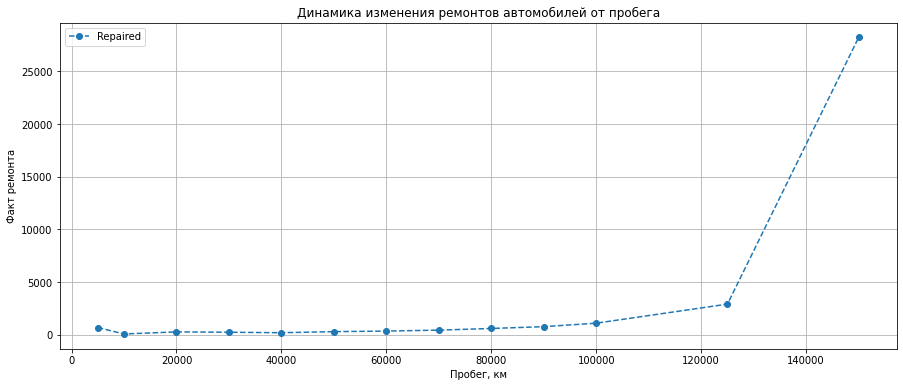

In [28]:
df.loc[df['Repaired'] == 'yes'].pivot_table(index='Kilometer', values='Repaired', aggfunc='count').plot(style='o--', figsize=(15, 6), grid=True)

plt.title('Динамика изменения ремонтов автомобилей от пробега')
plt.xlabel('Пробег, км')
plt.ylabel('Факт ремонта')

Из графика мы видим, что автомобилей с пробегом более 120 000 км, у которых был ремонт, значительно выростает. 

Отсюда можно предложить следующую замену пропущенных значений:
 
1) Если пробег > 120 000 км, то, вероятно, был ремонт.

2) Если пробег < 120 000 км, то, вероятно, ремонт не производился.

In [29]:
df['Repaired'] = df['Repaired'].fillna(df['Kilometer'] > 120000)
df.loc[df['Repaired'] == True, 'Repaired'] = 'yes'
df.loc[df['Repaired'] == False, 'Repaired'] = 'no'
df['Repaired'].value_counts()

no     260055
yes     94310
Name: Repaired, dtype: int64

### Исследовательский анализ, проверка на аномальные значения.

Рассмотрим, какие у нас встречаются аномальные значения в числовых признаках.

**Признак - Price**

Для начала расмотрим столбец с ценой Price.

<AxesSubplot:>

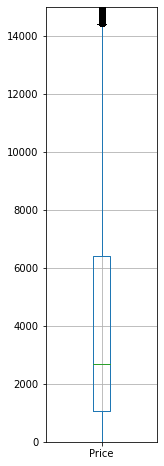

In [30]:
plt.figure(figsize=(2, 8))
plt.ylim(0,15000)
df.boxplot('Price')

<AxesSubplot:>

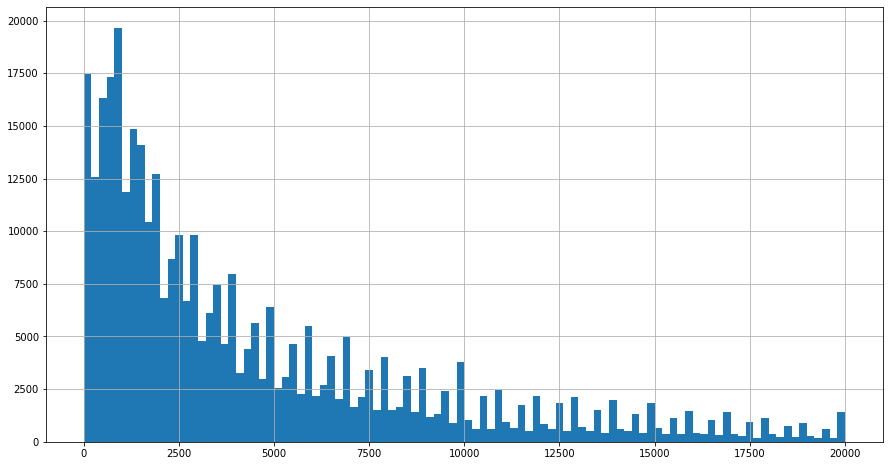

In [31]:
plt.figure(figsize=(15, 8))
df['Price'].hist(bins=100, range =(0,20000))

На основании представленных диаграмм мы видим, что имеется аномальное значение стоимости автомобиля - 0 Евро. Посмотрим, какие значения приведены в строках с нулевой ценой.

In [32]:
df.loc[df['Price'] == 0].head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,other,1990,other,0,corsa,150000,1,petrol,opel,yes,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,other,2017,manual,0,golf,5000,12,petrol,volkswagen,no,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,other,0,other,5000,0,petrol,volkswagen,no,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
154,2016-03-22 16:37:59,0,other,2006,other,0,other,5000,0,other,fiat,no,2016-03-22 00:00:00,0,44867,2016-04-06 06:17:56
231,2016-03-16 22:06:24,0,wagon,2001,manual,115,mondeo,150000,0,other,ford,yes,2016-03-16 00:00:00,0,57627,2016-03-26 11:17:50
334,2016-03-06 10:06:20,0,other,2005,other,0,polo,150000,0,petrol,volkswagen,yes,2016-03-06 00:00:00,0,35392,2016-03-07 19:12:00
415,2016-03-11 10:52:49,0,other,1985,other,0,3er,150000,0,other,bmw,yes,2016-03-11 00:00:00,0,85051,2016-03-11 11:41:09
466,2016-03-24 10:58:40,0,other,2016,auto,197,3er,150000,12,petrol,bmw,no,2016-03-24 00:00:00,0,99867,2016-03-25 19:46:09


In [33]:
zero_price = df.loc[df['Price'] == 0, 'Price'].count()/df['Price'].count()
zero_price
#df['Price'].count()

0.030398035923412302

Доля нулевых цен составляет 3%. При этом автомобили с нулевой ценой различаются по типу кузова , году выпуска, типу коробки передач, Пробегу и тд. Поэтому заменить 0 цену медианой, среденей или случайной будет не корректно. 

Учитывая, что доля данных машин незначительна, избавимся от них. В качестве нижнего порога возьмем стоимость машины 400 Евро.

In [34]:
df = df.loc[df['Price'] >=400]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324346 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        324346 non-null  object
 1   Price              324346 non-null  int64 
 2   VehicleType        324346 non-null  object
 3   RegistrationYear   324346 non-null  int64 
 4   Gearbox            324346 non-null  object
 5   Power              324346 non-null  int64 
 6   Model              324346 non-null  object
 7   Kilometer          324346 non-null  int64 
 8   RegistrationMonth  324346 non-null  int64 
 9   FuelType           324346 non-null  object
 10  Brand              324346 non-null  object
 11  Repaired           324346 non-null  object
 12  DateCreated        324346 non-null  object
 13  NumberOfPictures   324346 non-null  int64 
 14  PostalCode         324346 non-null  int64 
 15  LastSeen           324346 non-null  object
dtypes: int64(7), object(

**Год регистрации автомобиля - RegistrationYear**

<AxesSubplot:>

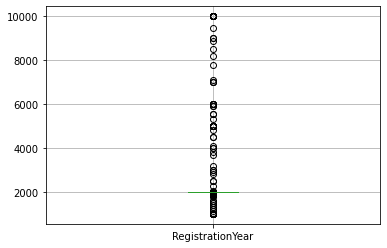

In [35]:
#plt.figure(figsize=(2, 8))
#plt.ylim(1900,2022)
df.boxplot('RegistrationYear')

Количество выбросов очень большое. Рассмотрим диаграмму размаха с периода 1900 по 2022 год и далее при необходимости будем сужать данный диапазон.

<AxesSubplot:>

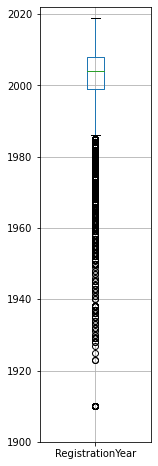

In [36]:
plt.figure(figsize=(2, 8))
plt.ylim(1900,2022)
df.boxplot('RegistrationYear')

<AxesSubplot:>

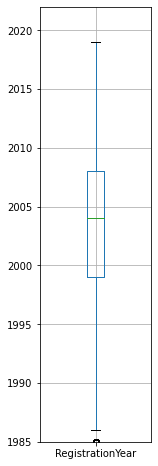

In [37]:
plt.figure(figsize=(2, 8))
plt.ylim(1985
         ,2022)
df.boxplot('RegistrationYear')

<AxesSubplot:>

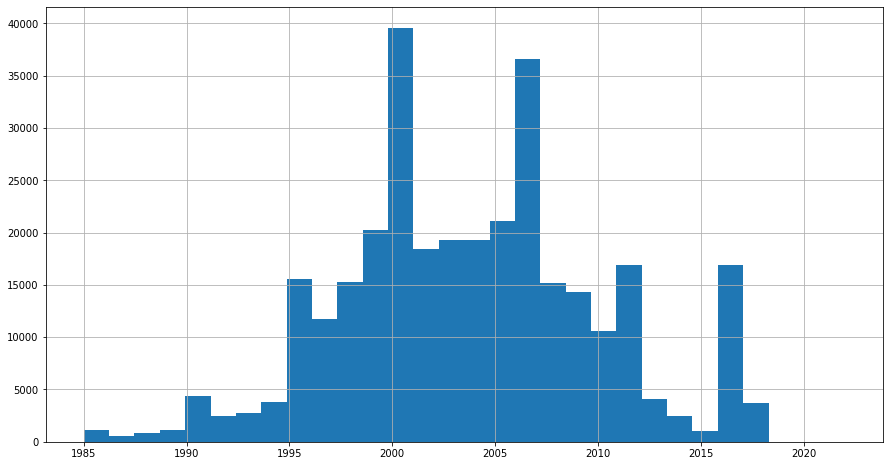

In [38]:
plt.figure(figsize=(15, 8))
df['RegistrationYear'].hist(bins=30, range =(1985,2022))

Как видно графиков, основной объем машин распределенс с 1985 по 2020 год. Остальных машин незначительное количество, поэтому от них можно избавиться.

Для выбора верхнего предела по годам автомобилей будем ориентироваться на признак даты создания анкеты DateCreated.

In [39]:
df_year= pd.DatetimeIndex(df['DateCreated']).year
df_year.max()

2016

Самая свежая анкета датируется 2016 годом, поэтому в качестве ограничителя сверху будем использовать данное значение.

In [40]:
df = df[(df['RegistrationYear'] >= 1985) & (df['RegistrationYear'] <= 2016)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306326 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        306326 non-null  object
 1   Price              306326 non-null  int64 
 2   VehicleType        306326 non-null  object
 3   RegistrationYear   306326 non-null  int64 
 4   Gearbox            306326 non-null  object
 5   Power              306326 non-null  int64 
 6   Model              306326 non-null  object
 7   Kilometer          306326 non-null  int64 
 8   RegistrationMonth  306326 non-null  int64 
 9   FuelType           306326 non-null  object
 10  Brand              306326 non-null  object
 11  Repaired           306326 non-null  object
 12  DateCreated        306326 non-null  object
 13  NumberOfPictures   306326 non-null  int64 
 14  PostalCode         306326 non-null  int64 
 15  LastSeen           306326 non-null  object
dtypes: int64(7), object(

**Мощность - Power**

<AxesSubplot:>

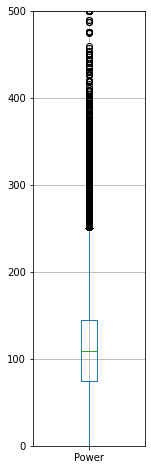

In [41]:
plt.figure(figsize=(2, 8))
plt.ylim(0,500)
df.boxplot('Power')

<AxesSubplot:>

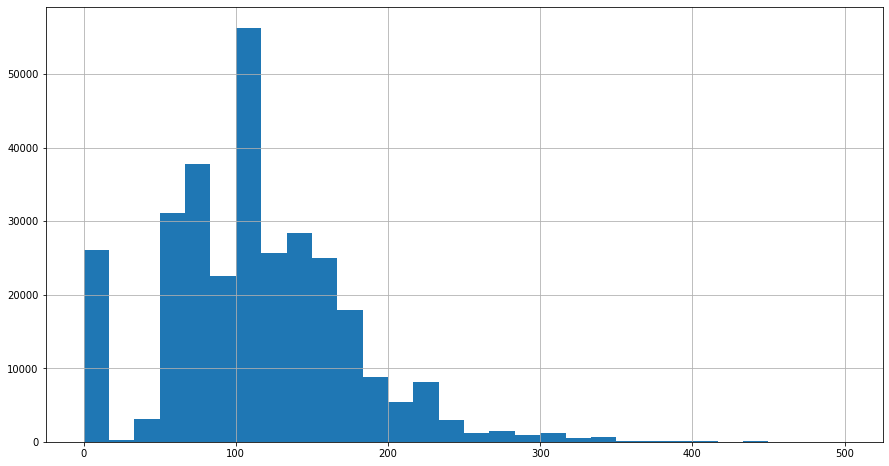

In [42]:
plt.figure(figsize=(15, 8))
df['Power'].hist(bins=30, range =(0,500))

Из графика видно, что имеется аномальное значение 0 л.с. Проверим долю, данных машин.

In [43]:
zero_power = df.loc[df['Power'] == 0, 'Power'].count()/df['Power'].count()
zero_power

0.08414564875328898

Дополнительно проверим долю автомобилей с мощностью более 500.

more_power = df.loc[df['Power'] > 500, 'Power'].count()/df['Power'].count()
more_powerКоличество автомоблиелей с 0 мощностью составляет порядка 10%, что значительно. 

Также имеется автомобиль с мощностью 20 000 л.с., что по сути является аномальным значением. При этом стоит отметить, что доля автомобилей с мощностью более 500 л.с. является незначительной

Учитывая, что все автомобили отличаются между собой по маркам, моделям, году выпуска, и т.д., заменим 0 л.с. на случайные значения мощности из диапазона 69 - 143 л.с. А в качестве диапазона мощности возьмем с 69 - 500 л.с.

In [44]:
rand_power = rn.randint(69, 143)
df['Power']= df['Power'].replace(to_replace=0, method='ffill')

df = df[(df['Power'] >= 69)& (df['Power'] <= 500)]

df['Power'].describe()

count    264709.000000
mean        132.785493
std          50.029207
min          69.000000
25%         101.000000
50%         122.000000
75%         155.000000
max         500.000000
Name: Power, dtype: float64

**Признак - RegistrationMonth**

In [45]:
df['RegistrationMonth'].value_counts(ascending=False)

3     26386
6     24434
4     22715
5     22568
7     21078
10    20466
11    19205
0     19031
12    18845
9     18646
8     17673
1     17518
2     16144
Name: RegistrationMonth, dtype: int64

<AxesSubplot:>

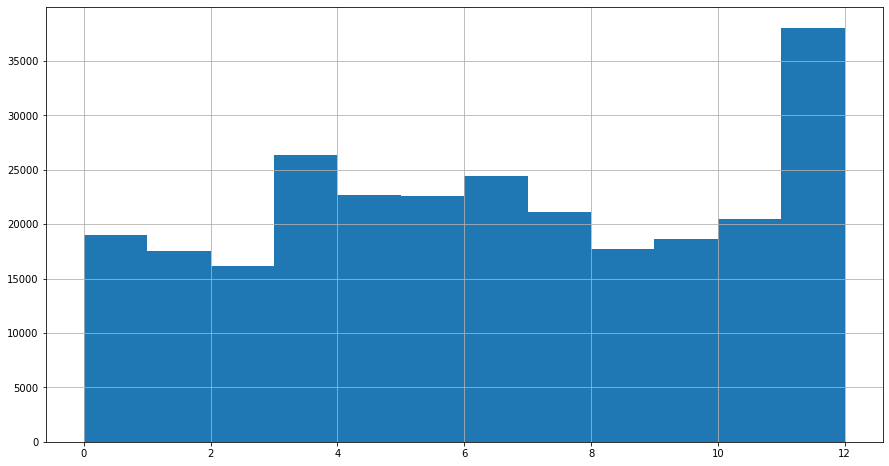

In [46]:
plt.figure(figsize=(15, 8))
df['RegistrationMonth'].hist(bins=12, range =(0,12))

Распределение по месяцам имеет отностительно равномерное распределение, за исключением декабря месяца.

Также видно, что имеется аномальный месяц 0. Можно предположить, что это ошибка в заполнении анкеты и прокуск самим хозяином анкеты.

Учитывая данное распределение, заменим 0 случайными числами от 1 до 12.

In [47]:
df['RegistrationMonth']= df['RegistrationMonth'].replace(to_replace=0, method='ffill')

rand_month = rn.randint(1, 12)
#df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'] = rand_month
df['RegistrationMonth'].value_counts(ascending=False)

3     28431
6     26290
4     24470
5     24256
7     22678
10    22058
11    20773
12    20279
9     20126
8     19059
1     18906
2     17383
Name: RegistrationMonth, dtype: int64

Дополнительно отметим, что фотографий в признаке NumberOfPictures нет. Учитывая, что фотографий нет, данный признак нам не пригодится в дальнейшем исседовании.

Выведем итоговую инфомрацию по предобработанному датасету.

In [48]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,petrol,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,yes,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264709 entries, 1 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        264709 non-null  object
 1   Price              264709 non-null  int64 
 2   VehicleType        264709 non-null  object
 3   RegistrationYear   264709 non-null  int64 
 4   Gearbox            264709 non-null  object
 5   Power              264709 non-null  int64 
 6   Model              264709 non-null  object
 7   Kilometer          264709 non-null  int64 
 8   RegistrationMonth  264709 non-null  int64 
 9   FuelType           264709 non-null  object
 10  Brand              264709 non-null  object
 11  Repaired           264709 non-null  object
 12  DateCreated        264709 non-null  object
 13  NumberOfPictures   264709 non-null  int64 
 14  PostalCode         264709 non-null  int64 
 15  LastSeen           264709 non-null  object
dtypes: int64(7), object(

In [50]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,264709.000000,264709.000000,264709.000000,264709.000000,264709.000000,264709.0,264709.000000
mean,5288.203435,2003.515339,132.785493,129217.480327,6.424595,0.0,51375.343385
std,4654.896607,5.703321,50.029207,36485.358337,3.345899,0.0,25819.369281
min,400.000000,1985.000000,69.000000,5000.000000,1.000000,0.0,1067.000000
25%,1650.000000,2000.000000,101.000000,125000.000000,4.000000,0.0,30952.000000
50%,3699.000000,2004.000000,122.000000,150000.000000,6.000000,0.0,50374.000000
75%,7600.000000,2007.000000,155.000000,150000.000000,9.000000,0.0,72229.000000
max,20000.000000,2016.000000,500.000000,150000.000000,12.000000,0.0,99998.000000


### Вывод по предобработке данных.

Проведена предобработка исходного датасета. Произведена очистка от всех аномальных значений, заполнены пропуски в категориальных и колличественных признаках.

## Обучение моделей

Задача предсказания цены относится к регрессионным моделям.

На данном этапе сделаем следующее:

1) Удалим из датасета неинфомративные признаки.

2) Произведем прямое кодирования категориальных признаков с целью их перевода в колличественные.

3) Разобъем полученную выборку на обучающую и тестовую выборку.

4) Произведем масштабирование колличественных признаков.

5) Методом GridSearchCV выберем одну из наилучших моделей регрессионного анализа: LGBMRegressor, LinearRegession, RandomForestRegessor. В качестве критерия оценки будем использовать метрику RMSE.

6) Проанализируем время обучения, время предсказания моделей.

Приступим к вышеуказанным шагам.

1) Удалим из датасета неинфомративные признаки.

Неинформативными признаками будут являться количество фотографий (NumberOfPictures), даты скачивания анкеты из базы, последней активности пользователя и создания анкеты (DateCrawled, LastSeen, DateCreated). Эти данные не помогут нам в расчете.

In [51]:
not_useful_col = ['NumberOfPictures','DateCrawled','LastSeen','DateCreated']
df_ready = df.drop(not_useful_col, axis=1)
df_ready.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264709 entries, 1 to 354364
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              264709 non-null  int64 
 1   VehicleType        264709 non-null  object
 2   RegistrationYear   264709 non-null  int64 
 3   Gearbox            264709 non-null  object
 4   Power              264709 non-null  int64 
 5   Model              264709 non-null  object
 6   Kilometer          264709 non-null  int64 
 7   RegistrationMonth  264709 non-null  int64 
 8   FuelType           264709 non-null  object
 9   Brand              264709 non-null  object
 10  Repaired           264709 non-null  object
 11  PostalCode         264709 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 26.3+ MB


2) Произведем прямое кодирования категориальных признаков с целью их перевода в колличественные.

In [52]:
df_ohe = pd.get_dummies(df_ready, drop_first=True)
df_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
1,18300,2011,190,125000,5,66954,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,8,90480,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1500,2001,75,150000,6,91074,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,7,60437,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,10,33775,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


3-4) Разобъем полученную выборку на обучающую и тестовую выборку. Произведем масштабирование колличественных признаков.

In [53]:
#features = df_ohe.drop(['Price'], axis=1)
#target = df_ohe['Price'] #целевой признак

#разбиваем иходную выборку на 2: тренировочную и тестовую.
df_train, df_test = train_test_split(df_ohe, test_size=0.25, random_state=12345)

features_train = df_train.drop(['Price'], axis=1)
target_train = df_train['Price']

features_test = df_test.drop(['Price'], axis=1)
target_test = df_test['Price']

scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

5) Методом GridSearchCV выберем одну из наилучших моделей регрессионного анализа: LGBMRegressor, LinearRegession. В качестве критерия оценки будем использовать метрику RMSE.


**LinearRegession**

In [54]:
%%time
model_lin_regr = LinearRegression()

parametrs_lin_regr = {'fit_intercept': ['True', 'False'],
                      'normalize': ['True', 'False'],
                      'n_jobs': [ -1, 1 ] }
grid_lin_rerg = GridSearchCV(model_lin_regr, parametrs_lin_regr,cv=5, scoring = 'neg_root_mean_squared_error')
grid_lin_rerg.fit(features_train, target_train)

print('Лучшие параметры LinearRegression:', grid_lin_rerg.best_params_)
print(f'Лучшее значение RMSE: {grid_lin_rerg.best_score_}')

Лучшие параметры LinearRegression: {'fit_intercept': 'True', 'n_jobs': -1, 'normalize': 'True'}
Лучшее значение RMSE: -2529.959200247347
CPU times: user 7min 37s, sys: 3min 32s, total: 11min 9s
Wall time: 11min 10s


In [55]:
grid_lin_rerg_df = pd.DataFrame(grid_lin_rerg.cv_results_)
display(grid_lin_rerg_df.head())
fit_time_lin_rerg = grid_lin_rerg_df[grid_lin_rerg_df['rank_test_score']==1]['mean_fit_time'].values[0]
pred_time_lin_rerg = grid_lin_rerg_df[grid_lin_rerg_df['rank_test_score']==1]['mean_score_time'].values[0]
print(f'Время обучения LinearRegression = {fit_time_lin_rerg}')
print(f'Время предсказания LinearRegression = {pred_time_lin_rerg}')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_intercept,param_n_jobs,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,15.822506,1.227473,0.090686,0.034335,True,-1,True,"{'fit_intercept': 'True', 'n_jobs': -1, 'norma...",-2522.001768,-2545.917993,-2538.800055,-2523.861608,-2519.214576,-2529.9592,10.476565,1
1,15.503909,1.016333,0.110649,0.060822,True,-1,False,"{'fit_intercept': 'True', 'n_jobs': -1, 'norma...",-2522.001768,-2545.917993,-2538.800055,-2523.861608,-2519.214576,-2529.9592,10.476565,1
2,18.490201,0.418435,0.066069,0.043283,True,1,True,"{'fit_intercept': 'True', 'n_jobs': 1, 'normal...",-2522.001768,-2545.917993,-2538.800055,-2523.861608,-2519.214576,-2529.9592,10.476565,1
3,18.335771,0.778192,0.101161,0.002175,True,1,False,"{'fit_intercept': 'True', 'n_jobs': 1, 'normal...",-2522.001768,-2545.917993,-2538.800055,-2523.861608,-2519.214576,-2529.9592,10.476565,1
4,18.494860,0.829457,0.080435,0.033626,False,-1,True,"{'fit_intercept': 'False', 'n_jobs': -1, 'norm...",-2522.001768,-2545.917993,-2538.800055,-2523.861608,-2519.214576,-2529.9592,10.476565,1


Время обучения LinearRegression = 15.822505569458007
Время предсказания LinearRegression = 0.09068641662597657


**LGBMRegressor**

Учитывая, что данная модель умеет работь с немасштабированными, а также категориальными признаками, за основу возьмем ранее предобработанную выборку  df_ready и разделим ее на обучающую и тестовую. 

Для начала изменим формат категориальных признаков на categoty.

In [56]:
df_ready['VehicleType'] = df_ready['VehicleType'].astype('category')
df_ready['Gearbox'] = df_ready['Gearbox'].astype('category')
df_ready['Model'] = df_ready['Model'].astype('category')
df_ready['FuelType'] = df_ready['FuelType'].astype('category')
df_ready['Brand'] = df_ready['Brand'].astype('category')
df_ready['Repaired'] = df_ready['Repaired'].astype('category')
 

In [57]:
df_train_ready, df_test_ready = train_test_split(df_ready, test_size=0.25, random_state=12345)

features_train_ready = df_train_ready.drop(['Price'], axis=1)
target_train_ready = df_train_ready['Price']

features_test_ready = df_test_ready.drop(['Price'], axis=1)
target_test_ready = df_test_ready['Price']


In [58]:
%%time
model_LGBMRegressor = LGBMRegressor(random_state = 12345)

parametrs_LGBMRegressor = {'boosting_type': ['gbdt', 'dart'],
                           'n_estimators': range (10, 51, 10)}

grid_LGBMRegressor = GridSearchCV(model_LGBMRegressor, parametrs_LGBMRegressor,cv=5,
                                  scoring = 'neg_root_mean_squared_error')
grid_LGBMRegressor.fit(features_train_ready, target_train_ready)

print('Лучшие параметры LinearRegression:', grid_LGBMRegressor.best_params_)
print(f'Лучшее значение RMSE: {grid_LGBMRegressor.best_score_}')

#'random_state' : [12345]

Лучшие параметры LinearRegression: {'boosting_type': 'gbdt', 'n_estimators': 50}
Лучшее значение RMSE: -1750.2861353930844
CPU times: user 46min 49s, sys: 18.8 s, total: 47min 8s
Wall time: 47min 30s


In [59]:
grid_LGBMRegressor_df = pd.DataFrame(grid_LGBMRegressor.cv_results_)
display(grid_LGBMRegressor_df.head())
fit_time_LGBMRegressor = grid_LGBMRegressor_df[grid_LGBMRegressor_df['rank_test_score']==1]['mean_fit_time'].values[0]
pred_time_LGBMRegressor = grid_LGBMRegressor_df[grid_LGBMRegressor_df['rank_test_score']==1]['mean_score_time'].values[0]
print(f'Время обучения LGBMRegressor= {fit_time_LGBMRegressor}')
print(f'Время предсказания LGBMRegressor= {pred_time_LGBMRegressor}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.968941,0.070839,0.066039,0.039952,gbdt,10,"{'boosting_type': 'gbdt', 'n_estimators': 10}",-2613.543862,-2625.982164,-2609.720755,-2619.975238,-2592.974087,-2612.439221,11.204504,8
1,1.512774,0.130406,0.104312,0.002852,gbdt,20,"{'boosting_type': 'gbdt', 'n_estimators': 20}",-2026.339648,-2036.865035,-2022.421004,-2035.045383,-2007.949584,-2025.724131,10.375255,4
2,2.036560,0.484339,0.161775,0.045090,gbdt,30,"{'boosting_type': 'gbdt', 'n_estimators': 30}",-1851.433135,-1857.107018,-1843.165298,-1854.482226,-1832.593875,-1847.756310,8.912570,3
3,75.061548,62.430612,0.239179,0.041228,gbdt,40,"{'boosting_type': 'gbdt', 'n_estimators': 40}",-1784.902139,-1788.552738,-1776.130695,-1786.370757,-1768.739952,-1780.939256,7.417763,2
4,23.698544,3.807178,0.279461,0.027695,gbdt,50,"{'boosting_type': 'gbdt', 'n_estimators': 50}",-1755.525732,-1757.857944,-1744.240361,-1755.819737,-1737.986903,-1750.286135,7.787540,1


Время обучения LGBMRegressor= 23.6985435962677
Время предсказания LGBMRegressor= 0.2794614315032959


Проведем обучение моделей.

In [64]:
%%time
model_lin_regr = LinearRegression(**grid_lin_rerg.best_params_)

model_lin_regr.fit(features_train, target_train)

pred_model_lin_regr = model_lin_regr.predict(features_train)

#print('RMSE-LinearRegression для обучающей выборки', (mean_squared_error(target_train, pred_model_lin_regr))**0.5)

CPU times: user 13 s, sys: 7.39 s, total: 20.4 s
Wall time: 20.6 s


In [65]:
%%time
model_LGBMRegressor = LGBMRegressor(**grid_LGBMRegressor.best_params_,random_state = 12345 )

model_LGBMRegressor.fit(features_train_ready, target_train_ready)

pred_model_LGBMRegressor = model_LGBMRegressor.predict(features_train_ready)

#print('RMSE-LGBMRegressor для обучающей выборки', (mean_squared_error(target_train, pred_model_LGBMRegressor))**0.5)

CPU times: user 29.8 s, sys: 188 ms, total: 30 s
Wall time: 30.2 s


**Вывод**
Модели обучены. Перейдем к их анализу.

## Анализ моделей

По результатам анализа выше видно, что модель линейной регрессии обучается и предсказывает быстрее, чем LGBMRegressor.

При этом скорость выполнения ячейки кода по команде %%time выше у LGBMRegressor. Более того следуюет отметить, что метрика RMSE также лучше у данной модели.

Проверим модель LGBMRegressor на тестовой выборке.

In [66]:
test_pred_model_LGBMRegressor = model_LGBMRegressor.predict(features_test_ready)
print('RMSE-LGBMRegressor для тестовой выборки', (mean_squared_error(target_test_ready, test_pred_model_LGBMRegressor))**0.5)

RMSE-LGBMRegressor для тестовой выборки 1750.9900862970808


# Общий вывод

По результатам предобработки исходных данных и подготовке выборок для обучения и предсказания, лучше всего проявила себя модель LGBMRegressor. Целевая метрика RMSE (ниже 2500) достигнута.

Лучшие параметры LinearRegression: {'boosting_type': 'gbdt', 'n_estimators': 50}